In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data=pd.read_csv("smile-annotations-final.csv")
data

,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap,nocode
0,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
1,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
2,614877582664835073,@Sofabsports thank you for following me back. ...,happy
3,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy
4,611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy
...,...,...,...
3079,613678555935973376,MT @AliHaggett: Looking forward to our public ...,happy
3080,613294681225621504,@britishmuseum Upper arm guard?,nocode
3081,615246897670922240,@MrStuchbery @britishmuseum Mesmerising.,happy
3082,613016084371914753,@NationalGallery The 2nd GENOCIDE against #Bia...,not-relevant


In [ ]:
data.rename(columns={"nocode":"emotion"},inplace=True)

In [ ]:
data["emotion"].value_counts()

nocode               1571
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: emotion, dtype: int64

In [ ]:
#Considering columns which has only valid emotions
df = data[~data.emotion.str.contains('\|')]
df = df[df.emotion != 'nocode']

In [ ]:
df.emotion.value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: emotion, dtype: int64

In [ ]:
labels=df.emotion.unique()
labels

array(['happy', 'not-relevant', 'angry', 'disgust', 'sad', 'surprise'],
      dtype=object)

In [ ]:
label_dict = {}
for index, possible_label in enumerate(labels):
    label_dict[possible_label] = index

label_dict

{'happy': 0,
 'not-relevant': 1,
 'angry': 2,
 'disgust': 3,
 'sad': 4,
 'surprise': 5}

In [ ]:
df['label'] = df["emotion"].replace(label_dict)
df

,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap,emotion,label
0,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
1,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
2,614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
3,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
4,611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0
...,...,...,...,...
3077,611258135270060033,@_TheWhitechapel @Campaignforwool @SlowTextile...,not-relevant,1
3078,612214539468279808,“@britishmuseum: Thanks for ranking us #1 in @...,happy,0
3079,613678555935973376,MT @AliHaggett: Looking forward to our public ...,happy,0
3081,615246897670922240,@MrStuchbery @britishmuseum Mesmerising.,happy,0


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


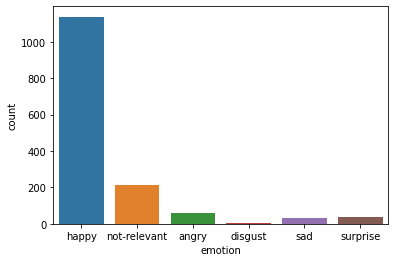

In [ ]:
sns.countplot(df["emotion"])

In [ ]:
df.rename(columns={"@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap":"tweet"},inplace=True)

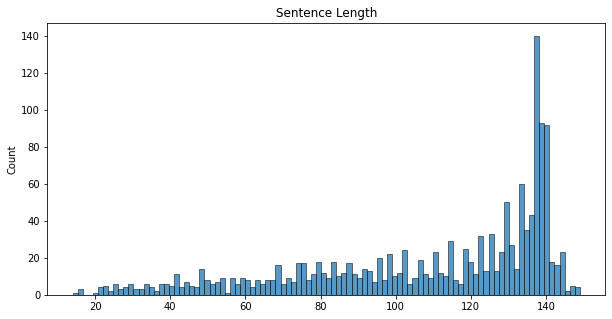

In [ ]:
#plot hist of sentence length
plt.figure(figsize=(10, 5))
sns.histplot([len(s) for s in df["tweet"]], bins=100)
plt.title('Sentence Length')
plt.show()

In [ ]:
#find the maximum length
max_len = max([len(sent) for sent in df["tweet"]])
print('Max length: ', max_len)

Max length:  149


In [ ]:
from sklearn.model_selection import train_test_split

#train test split
X_train, X_test, y_train, y_test = train_test_split(df["tweet"], 
                                                   df["label"],
                                                   test_size = 0.15,
                                                   random_state = 17,
                                                   stratify = df["label"])

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                         do_lower_case = True)

In [ ]:
train=pd.DataFrame({"Text":X_train,"emotion":y_train})
test= pd.DataFrame({"Text":X_test,"emotion":y_test})

Just like the other models, we have to convert the words into vectors. For that purpose we are using a bert method to do that task.

STEPS:

1.Adding special tokens (CLS and SEP). CLS is added in begining and SEP is added at the end.

eg: [CLS] Sentence A [SEP] Sentence B [SEP]

2.Then we are converting the sentences into a sequence of number

3.Also doing the masking operation, the output will be pytorch tensors

In [ ]:
#encode train set
#Converting each tweet into a sequence of numbers with the length of 256
#Output will be a dictionary of input_ids, token_type_ids and attention_mask
#Attention mask contains 0 as masked token and 1 as real token
encoded_data_train = tokenizer.batch_encode_plus(train["Text"].values,          
                                                add_special_tokes = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 256,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus(test["Text"].values,
                                                add_special_tokes = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 256,
                                                return_tensors = 'pt')

In [ ]:
encoded_data_train

{'input_ids': tensor([[  101,  1030,  4459,  ...,     0,     0,     0],
        [  101,  1030, 12323,  ...,     0,     0,     0],
        [  101,  1037,  2261,  ...,     0,     0,     0],
        ...,
        [  101,  1030,  2329,  ...,     0,     0,     0],
        [  101,  1030, 12869,  ...,     0,     0,     0],
        [  101,  1012,  1030,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
import torch
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train["emotion"].values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(test["emotion"].values)

In [ ]:
labels_train

tensor([0, 0, 0,  ..., 0, 0, 2])

Now we will set up our BERT model through 4 steps:

1.Load Pre-trained BERT

2.Create DataLoader

3.Set up optimizer

4.Set up scheduler

In [ ]:
#1.Loading pre-trained model
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
#2.Create dataloader
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [ ]:
#Creating iterator for ourdataset to save memory during training and boost the training speed.
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32)

* Optimizers are used in BERT (and in deep learning in general) to update the model parameters in the direction that minimizes the loss function. 

* Schedulers are used to adjust the learning rate during training, typically reducing the learning rate over time so that the optimizer can converge more efficiently to the optimal solution. 

* By using an optimizer and a scheduler, the model can converge faster and achieve better results than if only one or the other is used.

In [ ]:
#setup optimizer and scheduler
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) 
                 
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
device = torch.device("cpu")
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy() #converting tensors to numpy array
        label_ids = inputs['labels'].cpu().numpy() #converting tensors to numpy array
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds, average = 'weighted')

In [ ]:
#accuracy score
def accuracy_per_class(preds, labels):

  model.eval()
  correct_predictions=0
  total_predictions = 0
    
  with torch.no_grad():
    for input_ids, attention_masks, labels in dataloader_val:
      inputs = {
                'input_ids': input_ids.to(device),
                'attention_mask': attention_masks.to(device)
            }

      outputs = model(**inputs)
      logits = outputs[1]

      _, predicted_labels = torch.max(logits, dim=1) #Return max_value and index of the max_value
      correct_predictions += int((predicted_labels == labels.to(device)).sum()) #example output will be tensor(2) ----> int(2)
      total_predictions += labels.size(0) #Here labels.size(0) returns 32(batch size)
    
  accuracy = correct_predictions / total_predictions
  return accuracy

In [ ]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
'''
for epoch in range(1, epochs+1):
    
    model.train()

    accumulation_steps = 10
    
    loss_train_total = 0
    
    steps=0
    
    for input_ids,attention_masks,labels in dataloader_train:
        
        model.zero_grad() #set gradient to 0
        #since we are processing batch by batch, we set gradiant to zero initially.If we does not set to zero, then while computing gradient for 2nd batch
        #New gradient=1st batch gradient + 2nd batch gradient, to avoid this, we set gradient to zero
    
        
        #define inputs and loading it into CPU
        inputs = {'input_ids':input_ids.to(device),
                  'attention_mask':attention_masks.to(device),    #input=In simply,this a single tweet posted by a person
                  'labels':labels.to(device)}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        #output=(loss,logits)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        if (steps + 1) % accumulation_steps == 0:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            model.zero_grad()
        else:
            loss.backward()
        steps += 1
        #loss.backward() #computes the gradients of the loss with respect to the model parameters / slope 
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # This make sure that gradient value does not exceed more than 1
        
        #optimizer.step() # calculate new_weight=old_weight- learning rate * derivative of loss
        #scheduler.step() # It is used to update the learning rate of the optimizer
        
    torch.save(model.state_dict(), f'Models/ BERT_ft_epoch{epoch}.model')
    
    taining_loss = loss_train_total / len(dataloader_train)
    loss_val_avg, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)

    print('Epoch :',epoch)
    print('Training loss :', taining_loss)
    print('Validation loss :', loss_val_avg)
    print('F1 Score (weighted) :',val_f1)
    '''

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for input_ids,attention_masks,labels in progress_bar:
        
        model.zero_grad() #set gradient to 0
        #since we are processing batch by batch, we set gradient to zero else gradient2=gradient1+gradient2(This should not happen)
    
        inputs = {'input_ids':input_ids.to(device),
                  'attention_mask':attention_masks.to(device),    #input=In simply,this a single tweet posted by a person or single row
                  'labels':labels.to(device)}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        #outputs=(loss,logits)
        
        loss = outputs[0]
        loss_train_total += loss.item() #Example : loss_train_total=tensor(3) if we use loss.item then loss_train_total=3
        loss.backward() #calculates slope / gradient with respect to loss
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # It prevent the value of gradient not exeeding 1
        
        optimizer.step() #updating parameters/ weights
        scheduler.step() #Updating learning rate
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'Models/ BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')